# A03: Power Spectrum and Frequency Bands (Quick Version)

**Duration**: ~30 minutes  
**Prerequisites**: A01 (Signals and Sampling), A02 (The Frequency Domain)

> 💡 **Quick Version**: This notebook imports pre-built functions from `src/spectral.py` instead of defining them inline. For the full tutorial with step-by-step function implementations, see [A03_power_spectrum_frequency_bands.ipynb](A03_power_spectrum_frequency_bands.ipynb).

## Learning Objectives

By the end of this notebook, you will be able to:
- Understand the relationship between amplitude spectrum and power spectrum
- Compute Power Spectral Density (PSD) using both periodogram and Welch's method
- Explain the trade-off between frequency resolution and variance in spectral estimation
- Define and compute power in standard EEG frequency bands (delta, theta, alpha, beta, gamma)
- Convert between absolute and relative band power measures
- Use the decibel scale for visualizing power spectra

---

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [From Amplitude to Power](#section-2-from-amplitude-to-power)
3. [Power Spectral Density (PSD)](#section-3-power-spectral-density-psd)
4. [Welch's Method](#section-4-welchs-method)
5. [EEG Frequency Bands](#section-5-eeg-frequency-bands)
6. [Band Power Extraction](#section-6-band-power-extraction)
7. [Eyes Open vs Eyes Closed](#section-7-eyes-open-vs-eyes-closed)
8. [The Decibel Scale](#section-8-the-decibel-scale)
9. [Exercises](#section-9-exercises)
10. [Summary](#summary)
11. [External Resources](#external-resources)
12. [Discussion Questions](#discussion-questions)

---

In [1]:
# =============================================================================
# Imports
# =============================================================================

# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

# Local imports
src_path = Path.cwd().parents[2]
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from src.colors import COLORS
from src.plotting import configure_plots
from src.signals import generate_time_vector, generate_sine_wave
from src.spectral import (
    compute_amplitude_spectrum,
    compute_psd_fft,
    compute_psd_welch,
    compute_band_power,
    compute_all_band_powers,
    compute_relative_band_power,
    power_to_db,
)

# Apply plot configuration
configure_plots()

## Section 1: Introduction

In the previous notebook, we learned how the Fourier transform reveals the frequency content of signals through the **amplitude spectrum**. While amplitude tells us "how much" of each frequency is present, neuroscience research typically focuses on **power** — the squared amplitude.

Why power instead of amplitude? Power is directly related to the **energy** of oscillations. When we say "alpha power increased during eyes-closed rest," we're quantifying the energy contributed by 8-13 Hz oscillations.

This notebook covers:
- **Power Spectrum**: Square of amplitude spectrum
- **Power Spectral Density (PSD)**: Power normalized by frequency resolution
- **Welch's Method**: Averaged periodograms for variance reduction
- **Frequency Bands**: Delta, theta, alpha, beta, gamma

## Section 2: From Amplitude to Power

The **power spectrum** is the amplitude spectrum squared:

$$P(f) = |X(f)|^2$$

**Why square the amplitude?**
- Physical meaning: Power relates to energy
- Variance interpretation: Power at frequency $f$ equals the variance contributed by that frequency
- Squaring amplifies differences: 2× amplitude → 4× power

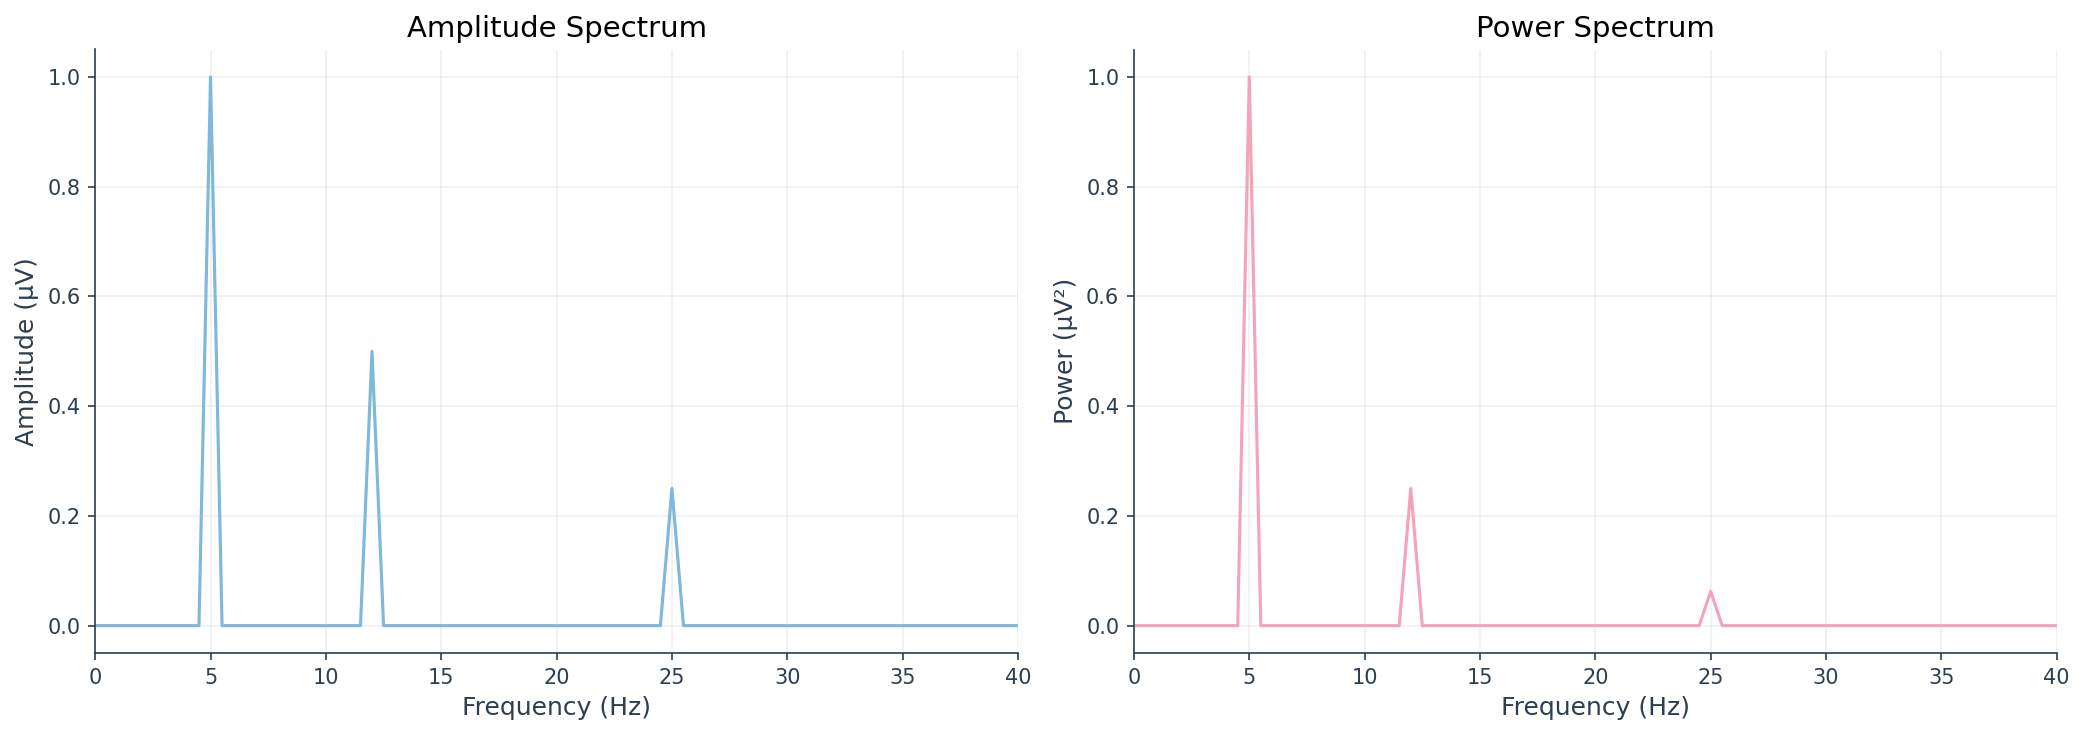

Amplitude ratios: 1.0 : 0.5 : 0.25
Power ratios:     1.0 : 0.25 : 0.0625 (squared)


In [2]:
# Visualization: Amplitude vs Power Spectrum

duration = 2.0
fs = 500
t = generate_time_vector(duration=duration, fs=fs)

# Create signal with components of different amplitudes
freq_1, amp_1 = 5, 1.0   # Reference amplitude
freq_2, amp_2 = 12, 0.5  # Half the amplitude
freq_3, amp_3 = 25, 0.25 # Quarter the amplitude

signal = (generate_sine_wave(t, frequency=freq_1, amplitude=amp_1) +
          generate_sine_wave(t, frequency=freq_2, amplitude=amp_2) +
          generate_sine_wave(t, frequency=freq_3, amplitude=amp_3))

# Compute amplitude spectrum
frequencies, amplitude = compute_amplitude_spectrum(signal, fs)
power = amplitude ** 2

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(frequencies, amplitude, color=COLORS["signal_1"], linewidth=1.5)
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Amplitude (µV)")
axes[0].set_title("Amplitude Spectrum")
axes[0].set_xlim(0, 40)
axes[0].grid(True, alpha=0.3)

axes[1].plot(frequencies, power, color=COLORS["signal_2"], linewidth=1.5)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Power (µV²)")
axes[1].set_title("Power Spectrum")
axes[1].set_xlim(0, 40)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Amplitude ratios: 1.0 : 0.5 : 0.25")
print("Power ratios:     1.0 : 0.25 : 0.0625 (squared)")

## Section 3: Power Spectral Density (PSD)

**Power Spectral Density** normalizes the power spectrum by frequency resolution:

$$S(f) = \frac{|X(f)|^2}{f_s \cdot N}$$

This gives PSD units of **µV²/Hz** — power per unit frequency. PSD values are comparable across recordings with different durations or sampling rates.

The `compute_psd_fft()` function computes the periodogram — a direct FFT-based PSD estimate.

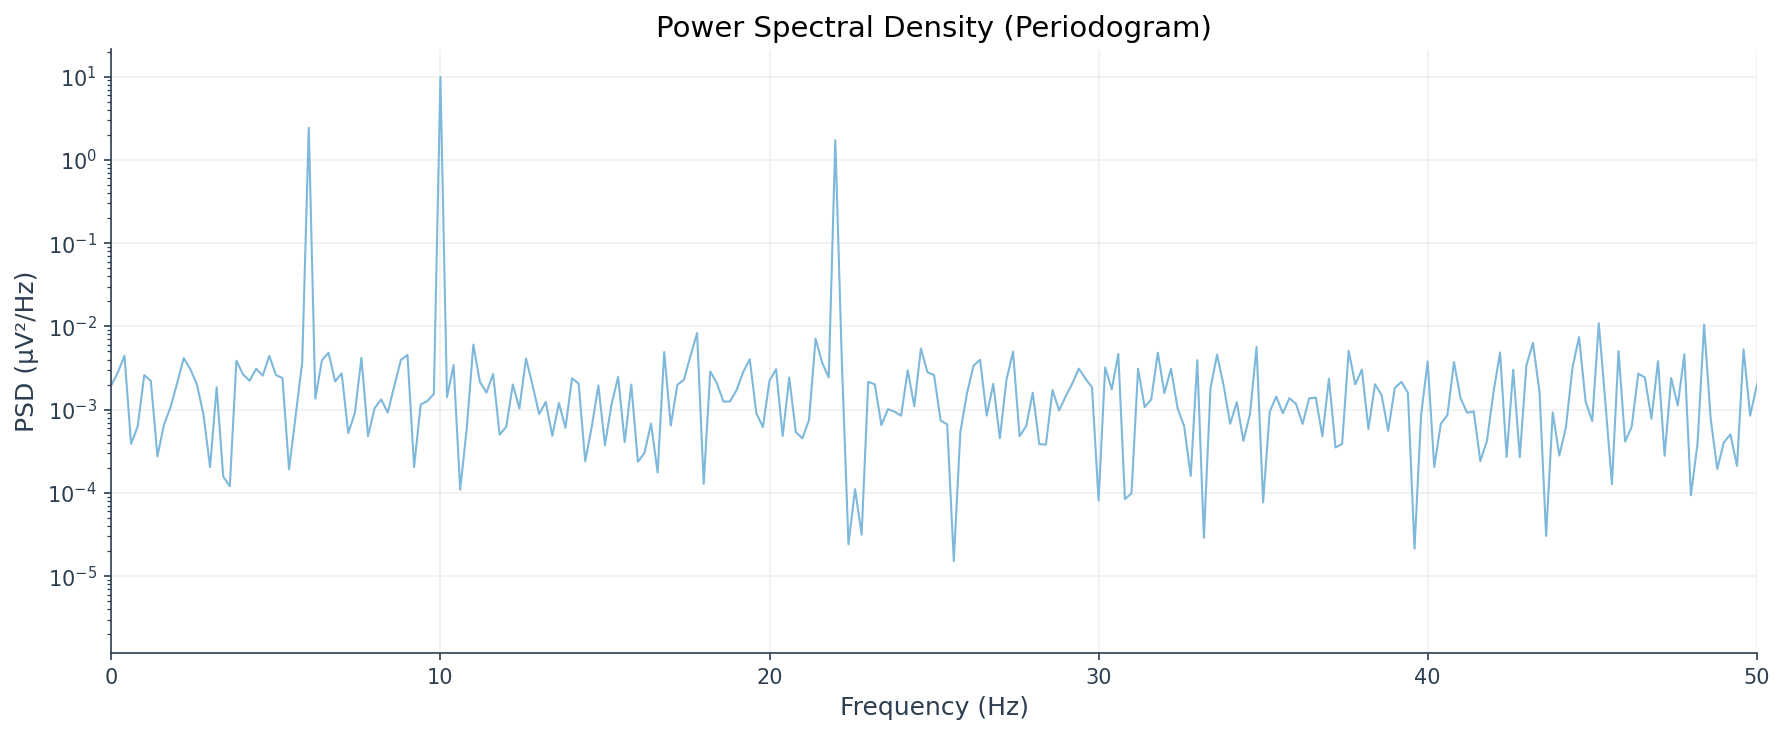

Peaks at 6 Hz (theta), 10 Hz (alpha), and 22 Hz (beta)


In [3]:
# Visualization: PSD of EEG-like signal

duration = 5.0
fs = 256
t = generate_time_vector(duration=duration, fs=fs)

# Create EEG-like signal with oscillations
np.random.seed(42)
alpha = generate_sine_wave(t, frequency=10, amplitude=2.0)
beta = generate_sine_wave(t, frequency=22, amplitude=0.8)
theta = generate_sine_wave(t, frequency=6, amplitude=1.0)
noise = np.random.randn(len(t)) * 0.5

eeg_signal = alpha + beta + theta + noise

# Compute PSD using periodogram
frequencies, psd = compute_psd_fft(eeg_signal, fs)

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.semilogy(frequencies, psd, color=COLORS["signal_1"], linewidth=1)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (µV²/Hz)")
ax.set_title("Power Spectral Density (Periodogram)")
ax.set_xlim(0, 50)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Peaks at 6 Hz (theta), 10 Hz (alpha), and 22 Hz (beta)")

## Section 4: Welch's Method

The periodogram has high variance — it's a "noisy" estimate. **Welch's method** reduces variance by:

1. **Dividing** the signal into overlapping segments
2. **Windowing** each segment to reduce spectral leakage
3. **Computing** periodogram of each segment
4. **Averaging** all periodograms

**Trade-off**: Longer segments → better frequency resolution but fewer averages → more variance.

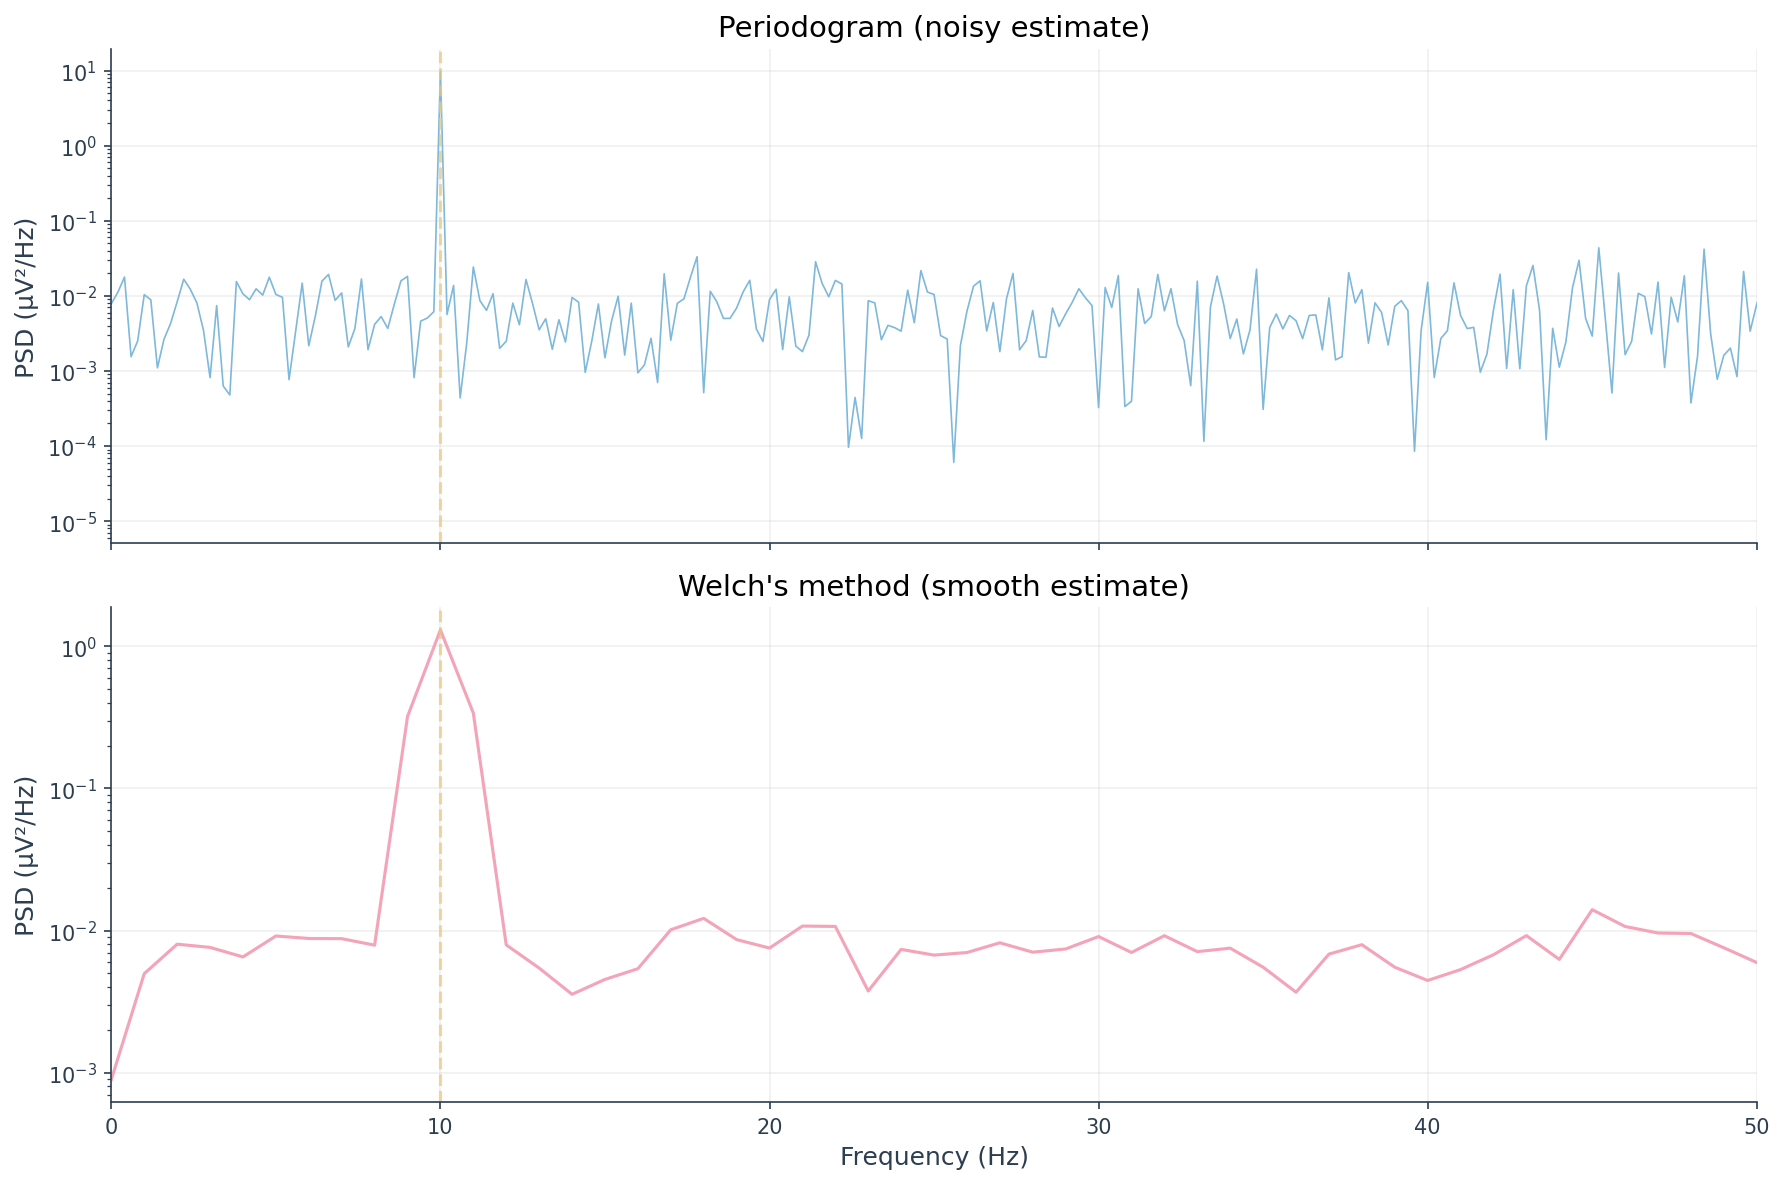

Welch's method produces a much smoother, more reliable estimate!


In [4]:
# Comparison: Periodogram vs Welch

duration = 5.0
fs = 256
t = generate_time_vector(duration=duration, fs=fs)

# Create noisy signal with alpha oscillation
np.random.seed(42)
signal = generate_sine_wave(t, frequency=10, amplitude=2.0)
noise = np.random.randn(len(t)) * 1.0
signal_noisy = signal + noise

# Compute both estimates
freq_periodo, psd_periodo = compute_psd_fft(signal_noisy, fs)
freq_welch, psd_welch = compute_psd_welch(signal_noisy, fs, nperseg=256)

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].semilogy(freq_periodo, psd_periodo, color=COLORS["signal_1"], linewidth=0.8)
axes[0].set_ylabel("PSD (µV²/Hz)")
axes[0].set_title("Periodogram (noisy estimate)")
axes[0].set_xlim(0, 50)
axes[0].axvline(10, color=COLORS["signal_4"], linestyle="--", alpha=0.7)
axes[0].grid(True, alpha=0.3)

axes[1].semilogy(freq_welch, psd_welch, color=COLORS["signal_2"], linewidth=1.5)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("PSD (µV²/Hz)")
axes[1].set_title("Welch's method (smooth estimate)")
axes[1].set_xlim(0, 50)
axes[1].axvline(10, color=COLORS["signal_4"], linestyle="--", alpha=0.7)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Welch's method produces a much smoother, more reliable estimate!")

## Section 5: EEG Frequency Bands

Neural oscillations are organized into **frequency bands**:

| Band | Range | Associated States |
|------|-------|-------------------|
| **Delta** (δ) | 1–4 Hz | Deep sleep, pathology |
| **Theta** (θ) | 4–8 Hz | Drowsiness, memory |
| **Alpha** (α) | 8–13 Hz | Relaxed wakefulness |
| **Beta** (β) | 13–30 Hz | Active thinking |
| **Gamma** (γ) | 30–100 Hz | Cognitive processing |

In [5]:
# Define EEG frequency bands
EEG_BANDS: dict[str, tuple[float, float]] = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta": (13.0, 30.0),
    "gamma": (30.0, 100.0),
}

# Colors from style guide
BAND_COLORS = {band: COLORS[band] for band in EEG_BANDS}

print("EEG Frequency Bands:")
for band, (f_low, f_high) in EEG_BANDS.items():
    print(f"  {band.capitalize():6s}: {f_low:4.1f} – {f_high:5.1f} Hz")

EEG Frequency Bands:
  Delta :  1.0 –   4.0 Hz
  Theta :  4.0 –   8.0 Hz
  Alpha :  8.0 –  13.0 Hz
  Beta  : 13.0 –  30.0 Hz
  Gamma : 30.0 – 100.0 Hz


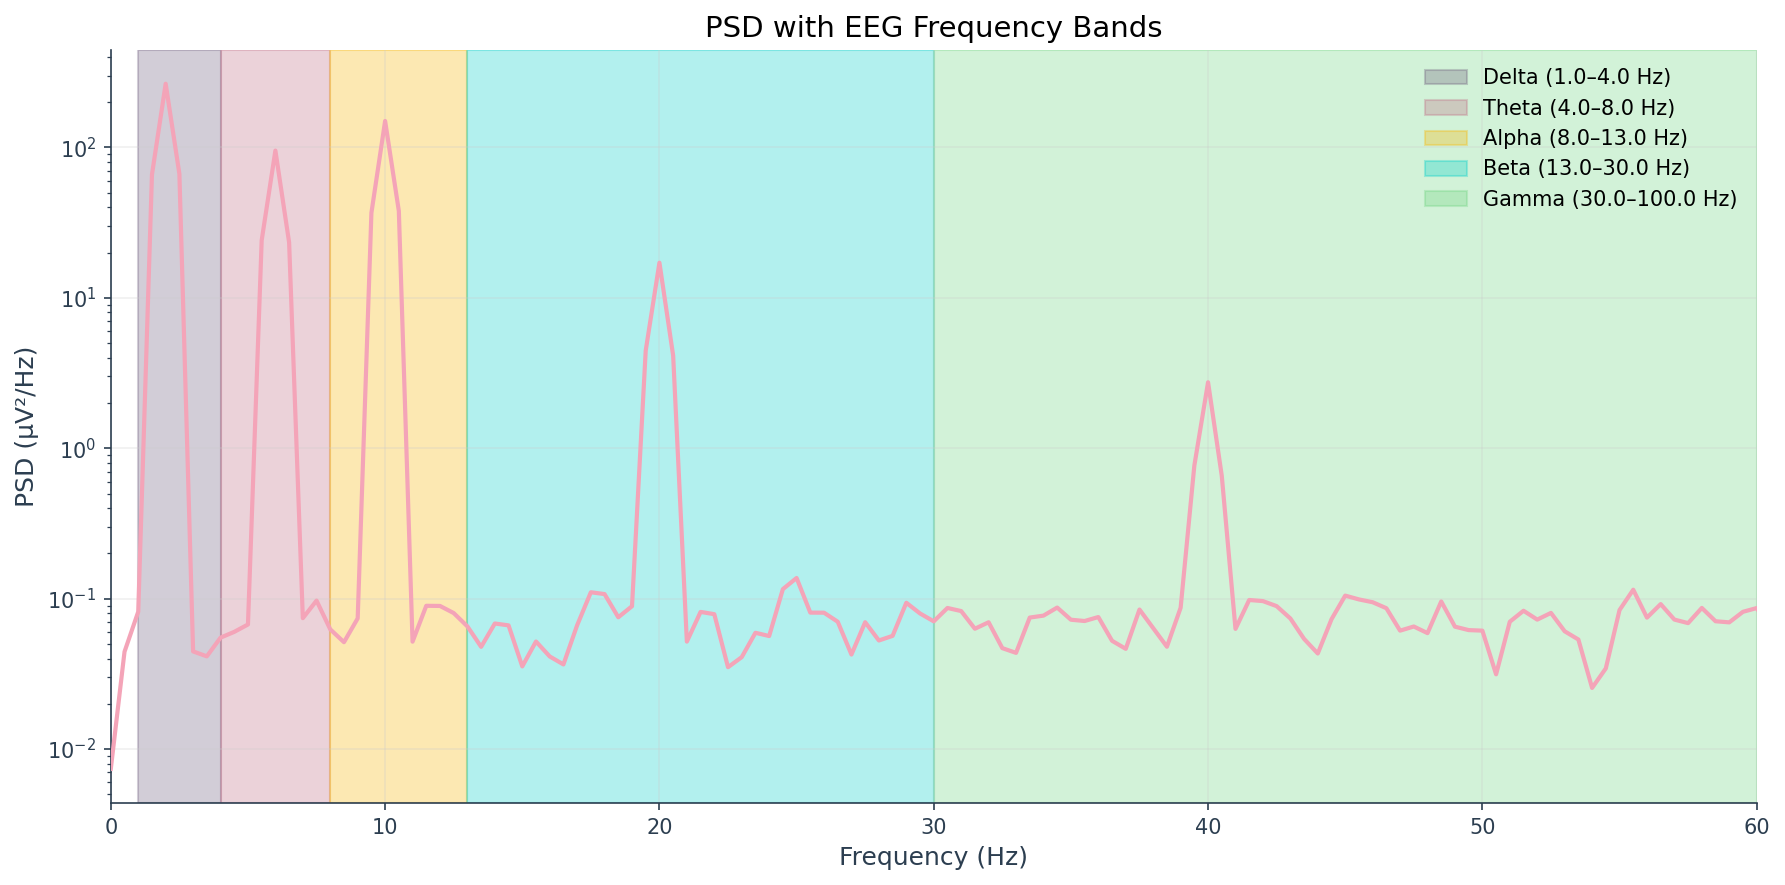

In [6]:
# Visualization: PSD with shaded frequency bands

fs = 256
duration = 10.0
t = generate_time_vector(duration, fs)

# Create multi-band signal
np.random.seed(42)
signal_delta = 20 * np.sin(2 * np.pi * 2 * t)
signal_theta = 12 * np.sin(2 * np.pi * 6 * t)
signal_alpha = 15 * np.sin(2 * np.pi * 10 * t)
signal_beta = 5 * np.sin(2 * np.pi * 20 * t)
signal_gamma = 2 * np.sin(2 * np.pi * 40 * t)
noise = 3 * np.random.randn(len(t))

composite_signal = signal_delta + signal_theta + signal_alpha + signal_beta + signal_gamma + noise

# Compute PSD
freqs, psd = compute_psd_welch(composite_signal, fs, nperseg=fs*2)

# Plot with bands
fig, ax = plt.subplots(figsize=(12, 6))
ax.semilogy(freqs, psd, color=COLORS["signal_2"], linewidth=2, zorder=5)

for band_name, (f_low, f_high) in EEG_BANDS.items():
    ax.axvspan(f_low, min(f_high, 60), alpha=0.3, color=BAND_COLORS[band_name],
               label=f"{band_name.capitalize()} ({f_low}–{f_high} Hz)")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (µV²/Hz)")
ax.set_title("PSD with EEG Frequency Bands")
ax.set_xlim(0, 60)
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 6: Band Power Extraction

**Absolute band power** is the integral of PSD over a frequency range:

$$P_{band} = \int_{f_{low}}^{f_{high}} S(f) \, df$$

**Relative band power** normalizes by total power:

$$P_{relative} = \frac{P_{band}}{P_{total}} \times 100\%$$

In [7]:
# Compute band powers
band_powers = compute_all_band_powers(psd, freqs, EEG_BANDS)

# Compute relative powers
relative_powers = {}
for band, freq_range in EEG_BANDS.items():
    relative_powers[band] = compute_relative_band_power(psd, freqs, freq_range)

# Display results
print("Band Powers:")
print(f"{'Band':<10} {'Absolute (µV²)':<18} {'Relative (%)':<12}")
print("-" * 40)
for band in EEG_BANDS:
    print(f"{band.capitalize():<10} {band_powers[band]:<18.2f} {relative_powers[band]:<12.1f}")

Band Powers:
Band       Absolute (µV²)     Relative (%)
----------------------------------------
Delta      198.92             49.3        
Theta      71.54              17.7        
Alpha      112.43             27.8        
Beta       13.93              3.5         
Gamma      6.88               1.7         


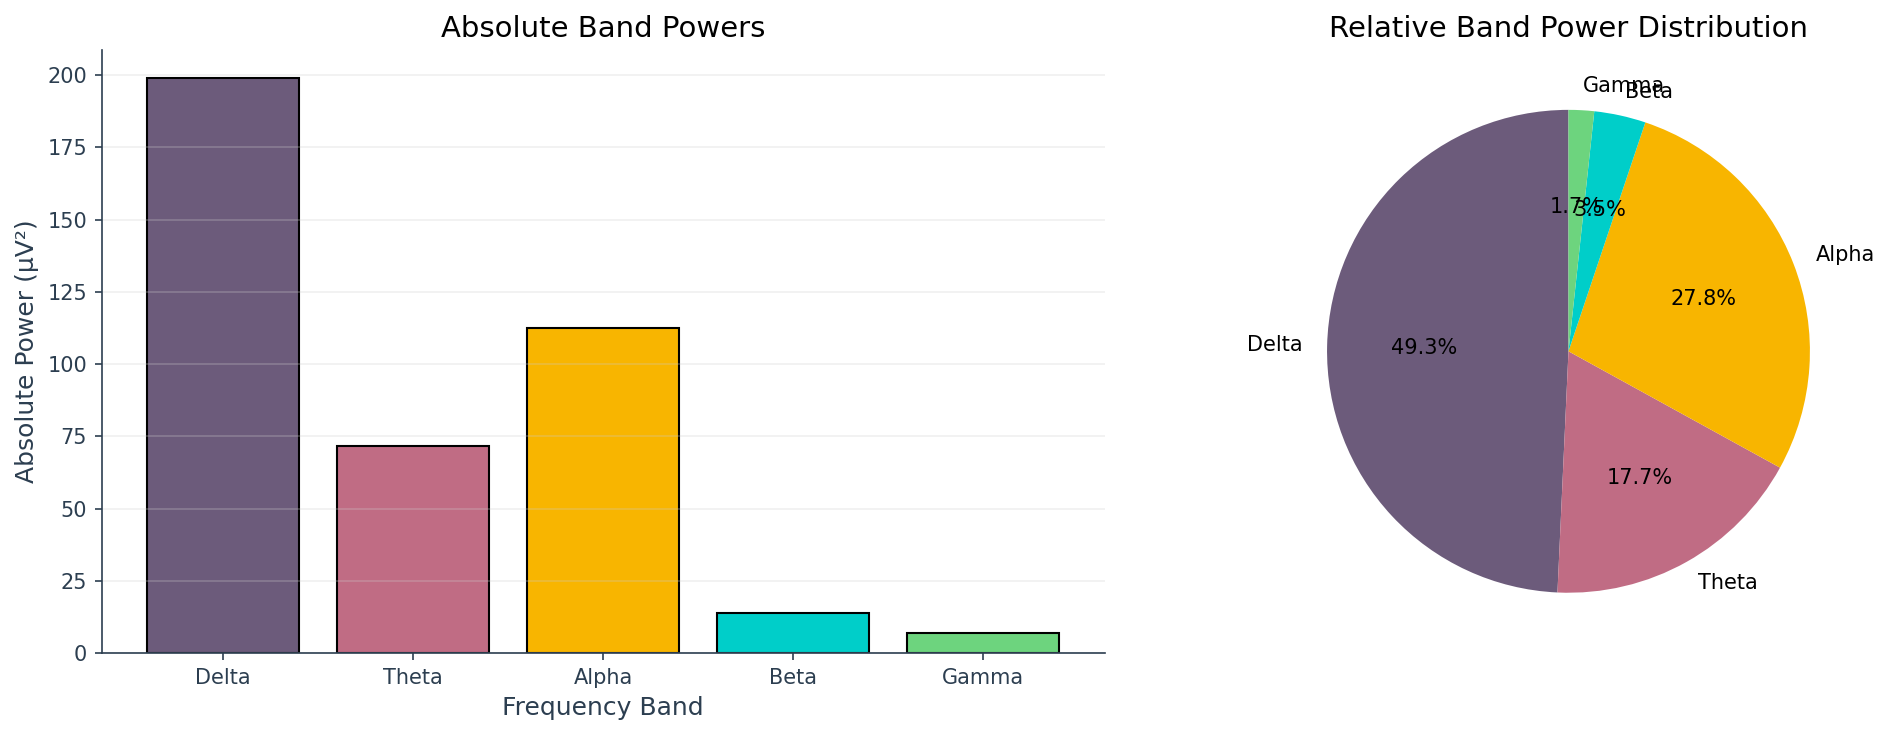

In [8]:
# Visualization: Bar chart of band powers

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

band_names = list(band_powers.keys())
powers = list(band_powers.values())
colors = [BAND_COLORS[band] for band in band_names]

# Absolute powers
axes[0].bar([b.capitalize() for b in band_names], powers, color=colors, edgecolor="black")
axes[0].set_xlabel("Frequency Band")
axes[0].set_ylabel("Absolute Power (µV²)")
axes[0].set_title("Absolute Band Powers")
axes[0].grid(True, axis="y", alpha=0.3)

# Relative powers (pie chart)
axes[1].pie(
    [relative_powers[band] for band in band_names],
    labels=[b.capitalize() for b in band_names],
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
)
axes[1].set_title("Relative Band Power Distribution")

plt.tight_layout()
plt.show()

## Section 7: Eyes Open vs Eyes Closed

One of the most robust findings in EEG: **alpha enhancement** when closing the eyes.

- **Eyes open**: Visual processing → alpha suppressed
- **Eyes closed**: Visual cortex idles → alpha power increases

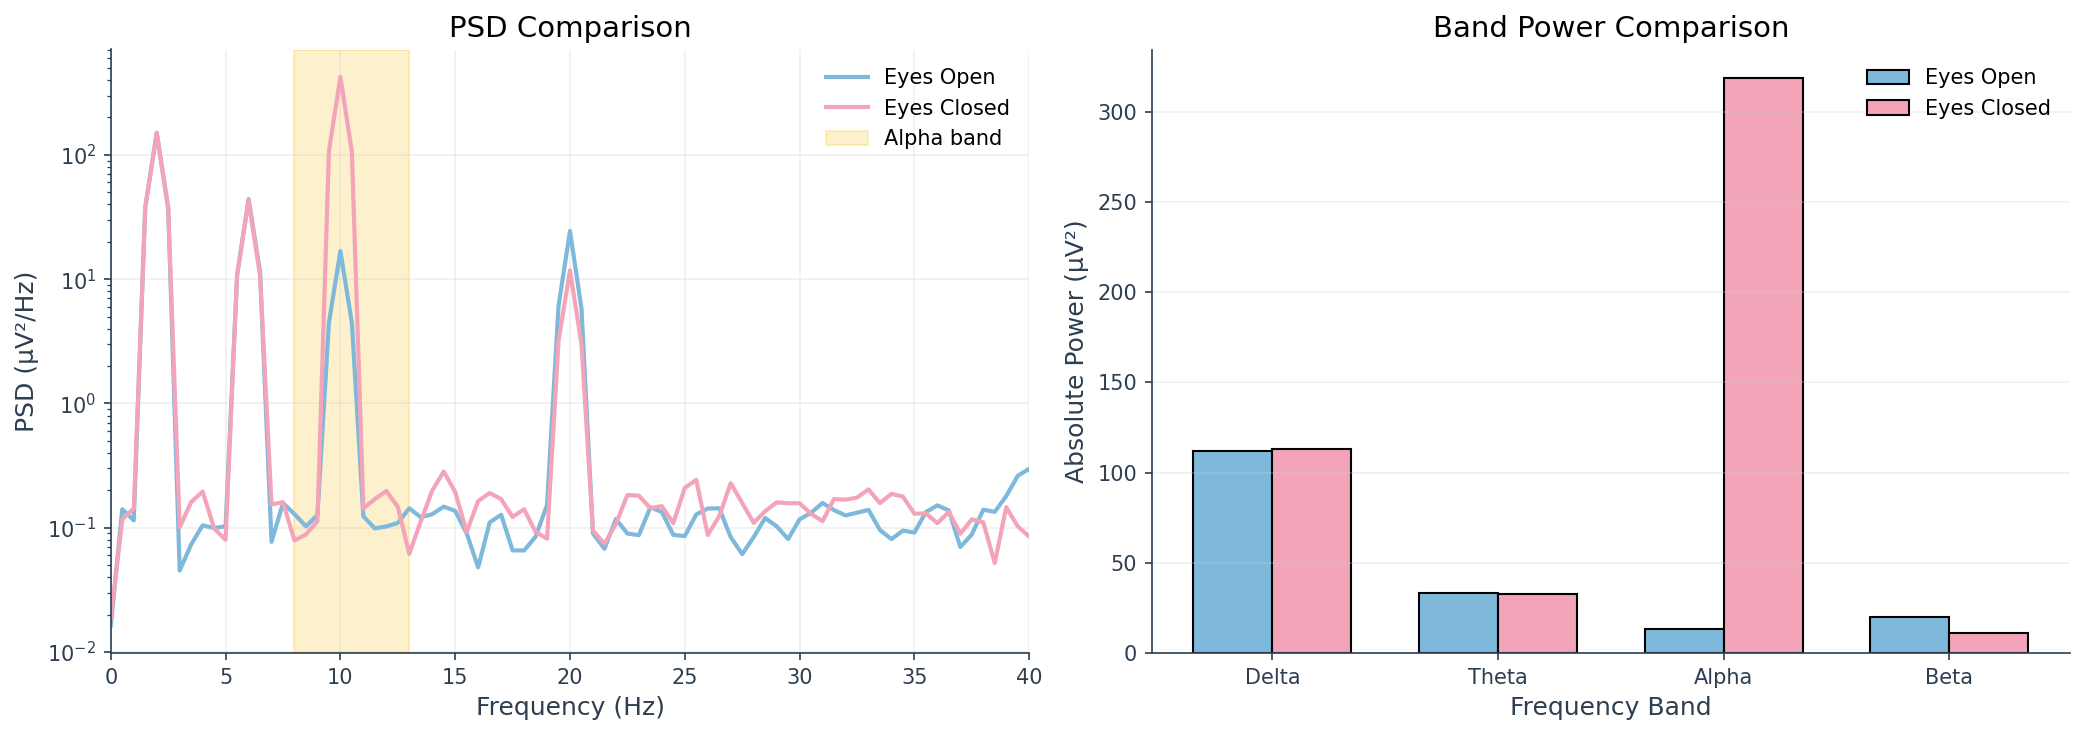

Alpha power ratio (Closed/Open): 24.0x


In [9]:
# Simulate eyes open vs eyes closed

fs = 256
duration = 10.0
t = generate_time_vector(duration, fs)
np.random.seed(123)

# Common components
delta = 15 * np.sin(2 * np.pi * 2 * t)
theta = 8 * np.sin(2 * np.pi * 6 * t)
beta = 4 * np.sin(2 * np.pi * 20 * t)

# Eyes OPEN: suppressed alpha
alpha_open = 5 * np.sin(2 * np.pi * 10 * t)
noise_open = 4 * np.random.randn(len(t))
signal_open = delta + theta + alpha_open + beta * 1.5 + noise_open

# Eyes CLOSED: enhanced alpha
alpha_closed = 25 * np.sin(2 * np.pi * 10 * t)
noise_closed = 4 * np.random.randn(len(t))
signal_closed = delta + theta + alpha_closed + beta + noise_closed

# Compute PSDs
freqs_open, psd_open = compute_psd_welch(signal_open, fs, nperseg=fs*2)
freqs_closed, psd_closed = compute_psd_welch(signal_closed, fs, nperseg=fs*2)

# Compute band powers
powers_open = compute_all_band_powers(psd_open, freqs_open, EEG_BANDS)
powers_closed = compute_all_band_powers(psd_closed, freqs_closed, EEG_BANDS)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PSD comparison
axes[0].semilogy(freqs_open, psd_open, color=COLORS["signal_1"], linewidth=2, label="Eyes Open")
axes[0].semilogy(freqs_closed, psd_closed, color=COLORS["signal_2"], linewidth=2, label="Eyes Closed")
axes[0].axvspan(8, 13, alpha=0.2, color=BAND_COLORS["alpha"], label="Alpha band")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("PSD (µV²/Hz)")
axes[0].set_title("PSD Comparison")
axes[0].set_xlim(0, 40)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Band power comparison
bands_to_plot = ["delta", "theta", "alpha", "beta"]
x = np.arange(len(bands_to_plot))
width = 0.35

axes[1].bar(x - width/2, [powers_open[b] for b in bands_to_plot], width,
            label="Eyes Open", color=COLORS["signal_1"], edgecolor="black")
axes[1].bar(x + width/2, [powers_closed[b] for b in bands_to_plot], width,
            label="Eyes Closed", color=COLORS["signal_2"], edgecolor="black")
axes[1].set_xlabel("Frequency Band")
axes[1].set_ylabel("Absolute Power (µV²)")
axes[1].set_title("Band Power Comparison")
axes[1].set_xticks(x)
axes[1].set_xticklabels([b.capitalize() for b in bands_to_plot])
axes[1].legend()
axes[1].grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

alpha_ratio = powers_closed["alpha"] / powers_open["alpha"]
print(f"Alpha power ratio (Closed/Open): {alpha_ratio:.1f}x")

## Section 8: The Decibel Scale

Power values can span many orders of magnitude. The **decibel (dB)** scale compresses this range:

$$P_{dB} = 10 \cdot \log_{10}\left(\frac{P}{P_{ref}}\right)$$

**Key relationships:**
- Doubling power ≈ +3 dB
- 10× power = +10 dB
- 100× power = +20 dB

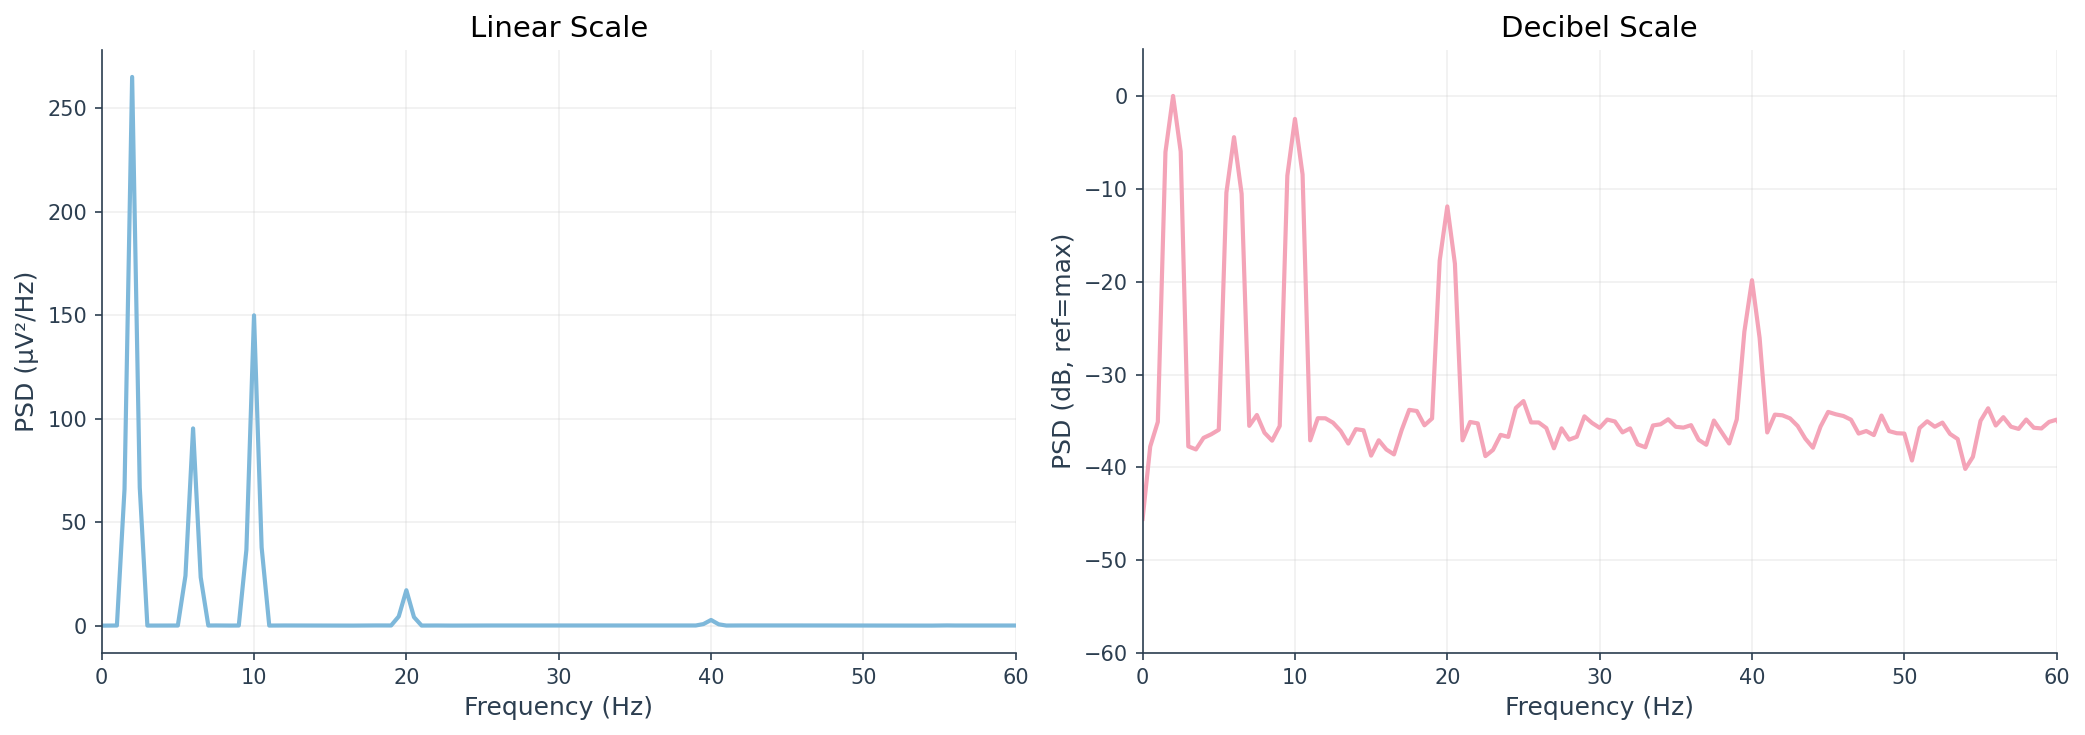

The dB scale reveals structure across the full dynamic range.


In [10]:
# Linear vs dB scale comparison

psd_db = power_to_db(psd, ref=np.max(psd))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].plot(freqs, psd, color=COLORS["signal_1"], linewidth=2)
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("PSD (µV²/Hz)")
axes[0].set_title("Linear Scale")
axes[0].set_xlim(0, 60)
axes[0].grid(True, alpha=0.3)

# dB scale
axes[1].plot(freqs, psd_db, color=COLORS["signal_2"], linewidth=2)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("PSD (dB, ref=max)")
axes[1].set_title("Decibel Scale")
axes[1].set_xlim(0, 60)
axes[1].set_ylim(-60, 5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The dB scale reveals structure across the full dynamic range.")

## Section 9: Exercises

Test your understanding with these hands-on exercises.

### 🎯 Exercise 1: Effect of nperseg on Welch PSD

Create a signal with a 10 Hz component and compare Welch PSD estimates using `nperseg` values of 64, 256, and 1024. How does segment length affect the trade-off between resolution and variance?

In [11]:
# Exercise 1: Your code here
# --------------------------

fs_ex = 256
duration_ex = 10.0
t_ex = generate_time_vector(duration_ex, fs_ex)

# Create signal: 10 Hz sine + noise
signal_ex = 5 * np.sin(2 * np.pi * 10 * t_ex) + np.random.randn(len(t_ex))

# TODO: Compute Welch PSD with different nperseg values and plot

<details>
<summary><strong>💡 Solution Exercise 1</strong></summary>

```python
fig, ax = plt.subplots(figsize=(10, 6))

for nperseg in [64, 256, 1024]:
    freqs, psd = compute_psd_welch(signal_ex, fs_ex, nperseg=nperseg)
    freq_res = fs_ex / nperseg
    ax.semilogy(freqs, psd, linewidth=2, label=f"nperseg={nperseg} (Δf={freq_res:.2f} Hz)")

ax.axvline(10, color="red", linestyle="--", alpha=0.5)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("PSD (µV²/Hz)")
ax.set_title("Effect of nperseg on Welch PSD")
ax.set_xlim(0, 30)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()
```

**Key insight:** Larger nperseg gives better frequency resolution but noisier estimates.

</details>

### 🎯 Exercise 2: Alpha/Beta Ratio

The alpha/beta ratio is used as an index of cortical arousal. Create "relaxed" (high alpha) and "alert" (high beta) signals, compute the ratio for each, and compare.

In [12]:
# Exercise 2: Your code here
# --------------------------

# TODO: Create relaxed and alert signals
# TODO: Compute alpha and beta power for each
# TODO: Calculate and compare alpha/beta ratios

<details>
<summary><strong>💡 Solution Exercise 2</strong></summary>

```python
t_ex2 = generate_time_vector(10.0, 256)
np.random.seed(42)

# Relaxed: strong alpha, weak beta
signal_relaxed = (15 * np.sin(2 * np.pi * 10 * t_ex2) +
                  3 * np.sin(2 * np.pi * 20 * t_ex2) +
                  2 * np.random.randn(len(t_ex2)))

# Alert: weak alpha, strong beta
signal_alert = (3 * np.sin(2 * np.pi * 10 * t_ex2) +
                12 * np.sin(2 * np.pi * 20 * t_ex2) +
                2 * np.random.randn(len(t_ex2)))

# Compute PSDs and band powers
freqs_r, psd_r = compute_psd_welch(signal_relaxed, 256, nperseg=512)
freqs_a, psd_a = compute_psd_welch(signal_alert, 256, nperseg=512)

alpha_r = compute_band_power(psd_r, freqs_r, (8, 13))
beta_r = compute_band_power(psd_r, freqs_r, (13, 30))
alpha_a = compute_band_power(psd_a, freqs_a, (8, 13))
beta_a = compute_band_power(psd_a, freqs_a, (13, 30))

print(f"Relaxed: Alpha/Beta = {alpha_r / beta_r:.2f}")
print(f"Alert:   Alpha/Beta = {alpha_a / beta_a:.2f}")
```

</details>

## Summary

### Key Concepts

| Concept | Description |
|---------|-------------|
| **Power Spectrum** | Amplitude² — represents energy distribution |
| **PSD** | Power per unit frequency (µV²/Hz) |
| **Periodogram** | Direct FFT estimate — high variance |
| **Welch's Method** | Averaged periodograms — reduced variance |
| **Frequency Bands** | δ, θ, α, β, γ — standard EEG divisions |
| **Band Power** | Integral of PSD over frequency range |
| **Decibel Scale** | 10·log₁₀(P/Pref) — compresses dynamic range |

### Functions Used

```python
from src.spectral import (
    compute_psd_fft,            # Periodogram
    compute_psd_welch,          # Welch method
    compute_band_power,         # Single band power
    compute_all_band_powers,    # All bands
    compute_relative_band_power, # Percentage
    power_to_db,                # dB conversion
)
```

## External Resources

### 🎥 Video Overview

> *Interactive video overview of this notebook's key concepts, generated with NotebookLM.*

[▶️ Watch the Video Overview](https://notebooklm.google.com/notebook/3d75df7a-91c7-4f12-a3f8-1047aea0e23b?artifactId=18b4b25d-2bda-4d12-9d34-d9022556d189)

### 📝 Practice & Review

Test your understanding with these AI-generated study materials:

- [**Quiz**: Power Spectrum and Frequency Bands](https://notebooklm.google.com/notebook/3d75df7a-91c7-4f12-a3f8-1047aea0e23b?artifactId=e7a2fcaf-d4ad-46f2-93d5-cc5c73b8b5e5) — Multiple choice questions on key concepts
- [**Flashcards**: Power Spectrum and Frequency Bands](https://notebooklm.google.com/notebook/3d75df7a-91c7-4f12-a3f8-1047aea0e23b?artifactId=a00d2a74-84d0-4d01-8222-63787492f3ea) — Review key terms and definitions

### 🎥 Video Tutorials

- [**Power Spectrum Explained**](https://www.youtube.com/watch?v=spUNpyF58BY) — Mike X Cohen explains power spectra for neural data (14 min)
- [**Welch's Method**](https://www.youtube.com/watch?v=wZsHtLiIDYY) — Understanding Welch's power spectral density estimation (10 min)
- [**EEG Frequency Bands**](https://www.youtube.com/watch?v=P8UWJc0tOVE) — Overview of delta, theta, alpha, beta, gamma rhythms (8 min)

### 📖 Further Reading

- [Power Spectral Density (Wikipedia)](https://en.wikipedia.org/wiki/Spectral_density) — Mathematical foundations of PSD
- [Welch's Method (Wikipedia)](https://en.wikipedia.org/wiki/Welch%27s_method) — The averaging approach to spectral estimation
- [Neural Oscillation (Wikipedia)](https://en.wikipedia.org/wiki/Neural_oscillation) — Frequency bands and their cognitive correlates
- [Mike X Cohen - Analyzing Neural Time Series Data](https://mikexcohen.com/book/) — Excellent textbook chapters on spectral analysis

## Discussion Questions

1. **Why does EEG show a 1/f spectrum?** What does this tell us about neural dynamics?

2. **Band boundaries are arbitrary.** Should we use individualized alpha peak frequency (IAF)?

3. **Absolute vs. Relative power:** When would you prefer one over the other?

4. **Welch parameters:** How would you choose `nperseg` for a real EEG analysis?

5. **Clinical applications:** How might spectral analysis help diagnose ADHD or Alzheimer's?